# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import csv
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

from zipfile import ZipFile

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


# Data Extraction

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [3]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'model.png', 'pat.txt', 'polar-user-data-export.zip', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weight_arima.ipynb', 'weight_rapport.ipynb', 'weight_recherche.ipynb']


In [4]:
class GetData():
    
    """
    Basic class to to all the data extraction work :
    - extracts the two files
    - replaces manually entered numbers for total mass and fat mass by calculated averages if available
    - provides method to export processed data
    """
    
    def __init__(self, zip_file_name, manual_file_name):
        self.zip_file_name = zip_file_name
        self.manual_follow_up_file_name = manual_file_name
        self.daily_mass_measurements = []
        self.daily_data = []
        self.data_dict = {}
    
    def extract(self):
        # extract data from the two files
        # first : data_BEN.zip
        
        root = os.getcwd() + '/'
        weight_file_path = root + 'tmp'

        with ZipFile(self.zip_file_name, 'r') as fichier_zip:
            print(f'Extraction fichier Zip Healthmate dans {weight_file_path}...')
            fichier_zip.extractall(path = weight_file_path)
            print(f'... Done')
        
        weight_file_csv_name = weight_file_path + '/weight.csv'
        fields = ['date', 
                  'MT', 
                  'MG']

        self.raw_from_zip = self.__extract_data(weight_file_csv_name, 
                                                fields,
                                                skip=1, 
                                                delimiter=',')  # gets a list of dictionnaries
        
        # 1/ self.raw_from_zip is a list of dictionnaries, that's the set of all mass measurements from Withings scale
        # there can be several measurements per day (and there usually are)
        
        # format is :
        # [ { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   ....,
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        # ]
                
        # second : Suivi_Poids.csv
        
        fields = ['date', 
                  'Masse Totale', 
                  'Masse Grasse', 
                  'Calories in', 
                  'Glucides', 'Lipides', 'Proteines', 
                  'Calories Exercice Brut', 'C_Ex_Cardio', 'C_Ex_Strength',
                  'Verif']
        
        self.raw_from_manual = self.__extract_data(self.manual_follow_up_file_name, 
                                                   fields,
                                                   skip=2, 
                                                   delimiter=';')  # returns and stores a list of disctionnaries
              
        
        # 2/ self.raw_from_manual is a list of dictionnaries, with one set of data per day, from a *.csv follow-up file
        
        # format is :
        # [ { 'date' : 'DD-month_name-YYYY', 'Masse Totale' : str of total mass, 'Masse Grasse' : str of fat mass,
        #     'Calories In' : str of kcals, 'Glucides' : str, 'Lipides' : str, 'Proteines' : str, 'Calories Exercice Brut': str,
        #     'C_Ex_Cardio': str, 'C_Ex_Strength': str, 'Verif': str, None: ['', '']
        #   },
        # ....
        # ]
        
        # ------------------------------
        # -- data consolidation --------
        # ------------------------------
        
        # 1/ creates an attribute self.daily_mass_measurements, which is a list of dictionnaries, containing all the mass measurements
        # per day, non empty, in float format - created from self.raw_from_zip
        
        # format is :
        
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        for cdict in self.raw_from_zip:
            cdate = self.__conv_to_date_num(cdict.get('date'))
            cmt = self.__conv_to_float(cdict.get('MT'))
            cmg = self.__conv_to_float(cdict.get('MG'))
            self.__add_daily_mass_measurement(cdate, cmt, cmg)
            
        # 2/ creates an attribute self.daily_data, which is a list of dictionnaries, containing all the measurements of the day
        # plus the calories data from the *.csv file (self.raw_from_manual)
        # if available in self.daily_mass_measurements, then the mass data in self.daily_data is overwritten by the averages
        # in self.daily_mass_measurements
        
        # format is :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        for cdict in self.raw_from_manual:
            cdate = self.__conv_to_date_str(cdict.get('date'))
            found, cmt, cmg = self.get_daily_mass_measurement(cdate)  # is the mass data in the Withings file ?
            if found:
                cmt = np.mean(cmt)
                cmg = np.mean(cmg)
            else:
                cmt = self.__conv_to_float(cdict.get('Masse Totale'))
                cmg = self.__conv_to_float(cdict.get('Masse Grasse'))
            cals_in = self.__conv_to_float(cdict.get('Calories in', '0.0'))
            glu = self.__conv_to_float(cdict.get('Glucides', '0.0'))
            lip = self.__conv_to_float(cdict.get('Lipides','0.0'))
            prot = self.__conv_to_float(cdict.get('Proteines', '0.0'))
            cals_ex = self.__conv_to_float(cdict.get('Calories Exercice Brut', '0.0'))
            cals_card = self.__conv_to_float(cdict.get('C_Ex_Cardio', '0.0'))
            cals_str = self.__conv_to_float(cdict.get('C_Ex_Strength', '0.0'))
            new_rec = dict([ ('date', cdate), 
                             ('masse_totale', cmt),
                             ('masse_grasse', cmg),
                             ('calories_in', cals_in),
                             ('glucides', glu),
                             ('lipides', lip),
                             ('proteines', prot),
                             ('calories_exercice', cals_ex),
                             ('calories_cardio', cals_card),
                             ('calories_strength', cals_str)
                             ])
            self.daily_data.append(new_rec)            
                    
    def __add_daily_mass_measurement(self, cdate : datetime.datetime, cmt : float, cmg : float):
        # utility : add cmt, cmg to the self.daily_mass_measurements records, or create it if first time
        found = False
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                self.daily_mass_measurements[i]['mt'].append(cmt)
                self.daily_mass_measurements[i]['mg'].append(cmg)
        if not found:
            new_rec = dict([ ('date', cdate), ('mt', [cmt]) , ('mg', [cmg]) ])
            self.daily_mass_measurements.append(new_rec)
            
    def get_daily_mass_measurement(self, cdate : datetime.datetime):
        # access to list of daily mass measurements
        # returns :
        # (True, list of mt measurements, list of mg measurements) if exist
        # (False, 0.0, 0.0) if does not exist
        found = False
        daily_mt = 0.0
        daily_mg = 0.0
        
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                daily_mt = daily_m_dict.get('mt')
                daily_mg = daily_m_dict.get('mg')
                
        return found, daily_mt, daily_mg
    
    def get_window_daily_mass_measurements(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of daily_mass_measurements between the two dates
        # format is, for the relevant dates :
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, daily_mt, daily_mg = self.get_daily_mass_measurement(cdate)
            if found:
                window.append( dict([ ('date',cdate), ('mt',daily_mt), ('mg', daily_mg) ]) )
                
        return window
    
    def get_daily_data(self, cdate : datetime.datetime):
        # access to list of daily data
        
        # returns :
        # (True, dict of dialy data if exist
        # (False, {}) if does not exist
        found = False
        ret_dict = {}
        
        for i, daily_m_dict in enumerate(self.daily_data):
            if daily_m_dict.get('date') == cdate:
                found = True
                ret_dict = self.daily_data[i]
                
        return found, ret_dict
    
    def get_window_daily_data(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of the daily data between the two dates
        # format is, for the relevant dates :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, cdict = self.get_daily_data(cdate)
            if found:
                window.append( cdict )
                
        return window
    
    def __extract_data(self,
                       filename, 
                       champs,
                       skip=2,
                       delimiter=','):
        """
        Helper function that reads a csv file, returns a list of dictionnaries
        Each dict is a line, ie a daily measurement, in the file.
        Skips the first line(s)
        
        Parameters :
        filename (str) : name of the *.csv file
        fieldnames (sequence) : sequence of the columns names
        skip (int) : number of lines to skip at the beginning of the file
        delimiter (str) : character used as a delimiter
        """

        data = []
        with open(filename, newline='') as csvfile:
            fichier = csv.DictReader(csvfile, fieldnames=champs, delimiter=delimiter)
            for i in range(skip):  # skip <skip> lines at the beginning of the file
                next(fichier)
            for row in fichier:
                data.append(row)

        return data
    
    def __conv_to_date_str(self, date_string : str) -> datetime.date:
        """
        helper function that converts string outputs of dates, 
        with format "YY-month_name-day", and returns a date object
        from datetime.
        """

        dict_mois = {'août' : 8, 
                     'sept.' : 9,
                     'oct.' : 10,
                     'nov.' : 11,
                     'déc.' : 12,
                     'janv.' : 1,
                     'févr.' : 2,
                     'mars' : 3,
                     'avr.' : 4,
                     'mai' : 5,
                     'juin' : 6,
                     'juil.' : 7
                    }
        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = 2000 + int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            try:
                month = dict_mois.get(d[1])
            except ValueError:
                raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_date_num(self, date_string : str) -> datetime.date:
        """
        helper function that converts a "YYYY-MM-DD" string into a date object
        """

        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_float(self, float_string:str) -> float:
        """
        conversion basique+ en float.

        renvoie 0 si string vide ou remplie d'espaces, ou string = '-'.
        """

        if type(float_string) is None:
            return 0

        float_string = float_string.replace(" ","")
        if not float_string:
            return 0
        if float_string == "-":
            return 0

        try:
            float_string = float_string.replace(" ","")
            valeur = float(float_string.replace(',','.'))
        except ValueError:
            raise NameError('une tentative de conversion en float a échouée car string non compatible')

        return valeur
    
    def get_dataframe(self):
        """Takes the data that has been extracted from the two files, returns a Dataframe

        Returns:
            df: dataframe
        """
        
        dict_ex = self.daily_data[0]  # assumes extraction has been done and self.daily_data has been created
        keys_names = list(dict_ex.keys())
        data_dict = { k: [] for k in keys_names} # initializes dictonnary to create dataframe
        for cdict in self.daily_data:
            for k,v in cdict.items():
                data_dict[k].append(v)
        df = pd.DataFrame.from_dict(data_dict)
        
        # removing rows with missing values in total mass, fat mass, or calories in.
        df.drop(df[df['masse_totale']==0.0].index, inplace=True)
        df.drop(df[df['masse_grasse']==0.0].index, inplace=True)
        df.drop(df[df['calories_in']==0.0].index, inplace=True)
        # keeping data after 1st september 2020
        df.drop(df[df['date']<datetime.date(2020,9,1)].index, inplace=True)
        
        return df

In [5]:
ds = GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


In [7]:
raw_df = ds.get_dataframe()

raw_df.set_index('date', inplace=True)

In [8]:
raw_df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength
date,,,,,,,,,
2020-09-01,101.250,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0
2020-09-02,101.150,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0
2020-09-03,101.200,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0
2020-09-04,100.800,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0
2020-09-05,100.600,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-12-15,68.200,8.394615,2202.0,200.0,65.0,210.0,399.0,0.0,399.0
2021-12-16,68.430,8.601000,2099.0,206.0,46.0,213.0,340.0,0.0,340.0
2021-12-17,68.665,8.680000,2155.0,256.0,46.0,181.0,457.0,0.0,457.0


### Dataframe with 'engineered' features

In [9]:
df = raw_df

# créée masse_seche
df['masse_seche'] = df['masse_totale'] - df['masse_grasse']

# calories nettes
df['calories_nettes'] = df['calories_in'] - df['calories_exercice']

# body fat percentage
df['bf_perc'] = df['masse_grasse'] / df['masse_totale']


In [10]:
# calcul du métabolisme de base :

# Katch-MacArdle -- considérée la plus précise si on connait le bf%

def kma(masse_seche, *kwargs):
    return 370 + 21.6 * masse_seche

# Mifflin Saint Jeor -- la plus précise par défaut

def msj(masse_totale, taille = 181, age = 53, *kwargs):
    return 9.99 * masse_totale + 6.25 * taille - 4.92 * age + 5

# Oxford -- pour info

def oxf(masse_totale, *kwargs):
    return 14.2 * masse_totale + 593

# Schofield -- pour info

def sch(masse_totale, *kwargs):
    return 11.472 * masse_totale + 873.1

In [11]:
df['msj'] = df['masse_totale'].apply(msj)
df['oxf'] = df['masse_totale'].apply(oxf)
df['sch'] = df['masse_totale'].apply(sch)
df['kma'] = df['masse_seche'].apply(kma)

# df['base_metabolism'] = df[['msj','oxf','sch','kma']].apply(np.mean, axis=1)
df['base_metabolism'] = df['kma']  # on utilise Katch Mac Ardle pour métabolisme de base

df['rest_metabolism'] = df['base_metabolism'] * 1.2  # 1.2 coeff, correspond au minimum d'activité physique (sédentaire)

df['calories_deficit'] = df['calories_in'] - df['rest_metabolism'] - df['calories_exercice']

In [12]:
df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,msj,oxf,sch,kma,base_metabolism,rest_metabolism,calories_deficit
date,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,68.230000,1734.0,0.326123,1886.97750,2030.750,2034.64000,1843.768000,1843.768000,2212.521600,-478.521600
2020-09-02,101.150,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,69.205000,1523.0,0.315818,1885.97850,2029.330,2033.49280,1864.828000,1864.828000,2237.793600,-714.793600
2020-09-03,101.200,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,70.270000,1535.0,0.305632,1886.47800,2030.040,2034.06640,1887.832000,1887.832000,2265.398400,-730.398400
2020-09-04,100.800,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,71.340000,1412.0,0.292262,1882.48200,2024.360,2029.47760,1910.944000,1910.944000,2293.132800,-881.132800
2020-09-05,100.600,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,69.150000,1211.0,0.312624,1880.48400,2021.520,2027.18320,1863.640000,1863.640000,2236.368000,-1025.368000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-15,68.200,8.394615,2202.0,200.0,65.0,210.0,399.0,0.0,399.0,59.805385,1803.0,0.123088,1556.80800,1561.440,1655.49040,1661.796308,1661.796308,1994.155569,-191.155569
2021-12-16,68.430,8.601000,2099.0,206.0,46.0,213.0,340.0,0.0,340.0,59.829000,1759.0,0.125690,1559.10570,1564.706,1658.12896,1662.306400,1662.306400,1994.767680,-235.767680
2021-12-17,68.665,8.680000,2155.0,256.0,46.0,181.0,457.0,0.0,457.0,59.985000,1698.0,0.126411,1561.45335,1568.043,1660.82488,1665.676000,1665.676000,1998.811200,-300.811200


In [13]:
def plot_columns(df = df,
                 columns_list = ['masse_totale', 'masse_grasse', 'masse_seche', 'bf_perc',
                                 'calories_in', 'rest_metabolism', 
                                 'calories_cardio', 'calories_strength', 'calories_deficit']):
    
    
    nb_cols_per_row = 3
    n = len(columns_list)
    
    if (n % nb_cols_per_row) == 0:
        n_rows = n // nb_cols_per_row
        n_cols = nb_cols_per_row
    else:
        n_rows = n // nb_cols_per_row + 1
        n_cols = nb_cols_per_row
        
    row_size = 8
    col_size = 8
    
    fig, axs = plt.subplots(nrows = n_rows, 
                            ncols = n_cols,
                            figsize=(row_size * nb_cols_per_row, 
                                     col_size * n_rows))
    
    if axs.ndim == 1: axs = axs[np.newaxis,:]  # required to make sure the axs array is actually 2D...
     
    for i, name in enumerate(columns_list):
        row_i = i // nb_cols_per_row
        col_i = i - row_i * nb_cols_per_row
        # print(i, row_i, col_i)
        
        axs[row_i, col_i] = df[name].plot(ax=axs[row_i, col_i], title=name + f' vs temps',grid=True)
                
    plt.show()

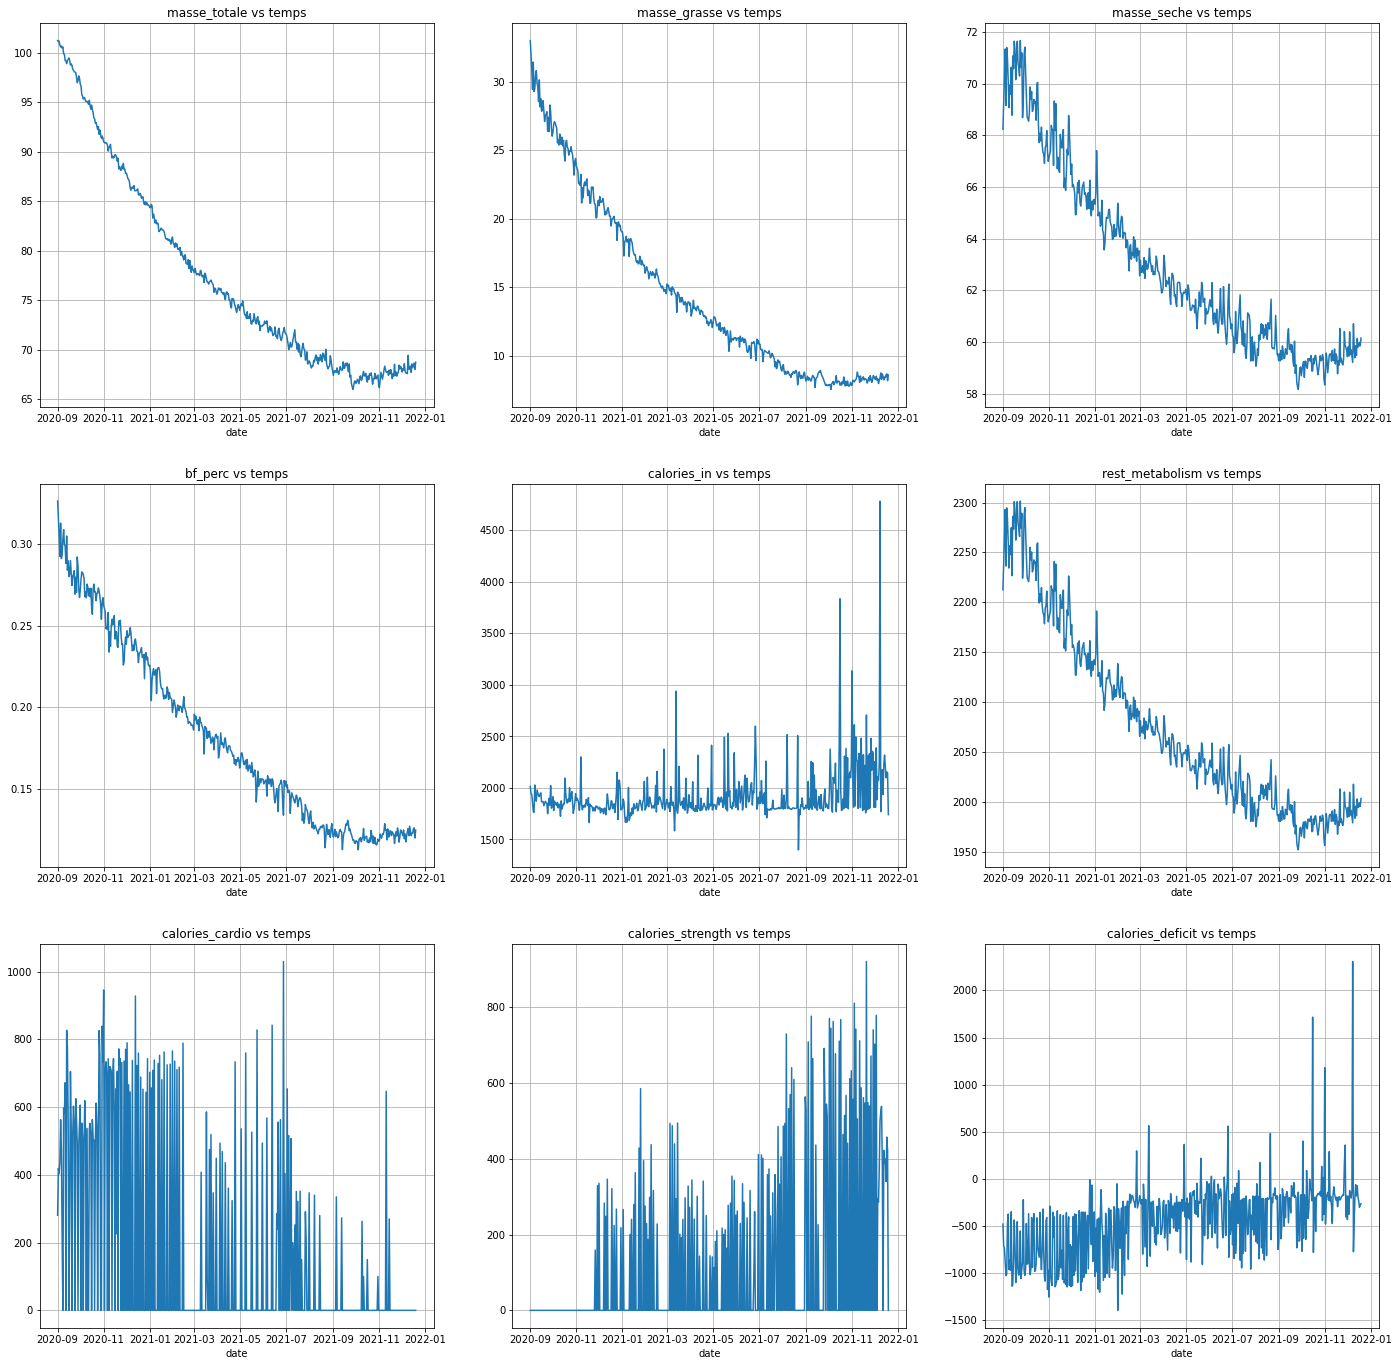

In [14]:
plot_columns()

# On distingue deux périodes :
- une période de "sèche" jusqu'à fin septembre 2021 environ
- une période de "bulk" plus ou moins clean (?) à partir d'octobre 2021

In [15]:
cut_off = datetime.date(2021,10,1)

df_seche = df[df.index < cut_off]
df_bulk = df[df.index >= cut_off]

In [16]:
df_seche

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,msj,oxf,sch,kma,base_metabolism,rest_metabolism,calories_deficit
date,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,68.230000,1734.0,0.326123,1886.977500,2030.750000,2034.640000,1843.768000,1843.768000,2212.521600,-478.521600
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,69.205000,1523.0,0.315818,1885.978500,2029.330000,2033.492800,1864.828000,1864.828000,2237.793600,-714.793600
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,70.270000,1535.0,0.305632,1886.478000,2030.040000,2034.066400,1887.832000,1887.832000,2265.398400,-730.398400
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,71.340000,1412.0,0.292262,1882.482000,2024.360000,2029.477600,1910.944000,1910.944000,2293.132800,-881.132800
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,69.150000,1211.0,0.312624,1880.484000,2021.520000,2027.183200,1863.640000,1863.640000,2236.368000,-1025.368000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,66.250000,7.985000,1990.0,167.0,63.0,168.0,566.0,0.0,566.0,58.265000,1424.0,0.120528,1537.327500,1533.750000,1633.120000,1628.524000,1628.524000,1954.228800,-530.228800
2021-09-27,66.000000,7.835714,1812.0,121.0,53.0,172.0,0.0,0.0,0.0,58.164286,1812.0,0.118723,1534.830000,1530.200000,1630.252000,1626.348571,1626.348571,1951.618286,-139.618286
2021-09-28,66.433333,7.908333,1845.0,168.0,55.0,167.0,544.0,0.0,544.0,58.525000,1301.0,0.119042,1539.159000,1536.353333,1635.223200,1634.140000,1634.140000,1960.968000,-659.968000


In [17]:
df_seche.describe()

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,msj,oxf,sch,kma,base_metabolism,rest_metabolism,calories_deficit
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,79.572731,15.884847,1872.154430,177.946835,58.810127,129.792405,277.632911,195.232911,82.400000,63.687885,1594.521519,0.193252,1670.421587,1722.932787,1785.958375,1745.658311,1745.658311,2094.789973,-500.268454
std,9.694319,6.348998,145.471486,41.029638,14.950405,29.082369,295.954182,292.398130,164.693815,3.417248,310.521874,0.053089,96.846250,137.659334,111.213231,73.812555,73.812555,88.575066,347.263016
min,66.000000,7.685000,1399.000000,43.000000,8.000000,13.000000,0.000000,0.000000,0.000000,58.164286,745.000000,0.113084,1534.830000,1530.200000,1630.252000,1626.348571,1626.348571,1951.618286,-1393.390400
25%,71.583333,10.690000,1799.000000,154.000000,48.000000,114.000000,0.000000,0.000000,0.000000,60.908333,1326.500000,0.149729,1590.607500,1609.483333,1694.304000,1685.620000,1685.620000,2022.744000,-771.688800
50%,77.050000,14.260000,1831.000000,173.000000,58.000000,133.000000,220.000000,0.000000,0.000000,62.776667,1654.000000,0.185426,1645.219500,1687.110000,1757.017600,1725.976000,1725.976000,2071.171200,-425.499200
75%,86.416667,20.616667,1890.500000,199.500000,69.500000,147.000000,544.500000,489.500000,0.000000,65.988333,1818.000000,0.236989,1738.792500,1820.116667,1864.472000,1795.348000,1795.348000,2154.417600,-219.439200
max,101.250000,33.020000,2940.000000,334.000000,106.000000,225.000000,1041.000000,1030.000000,776.000000,71.663333,2646.000000,0.326123,1886.977500,2030.750000,2034.640000,1917.928000,1917.928000,2301.513600,564.979200


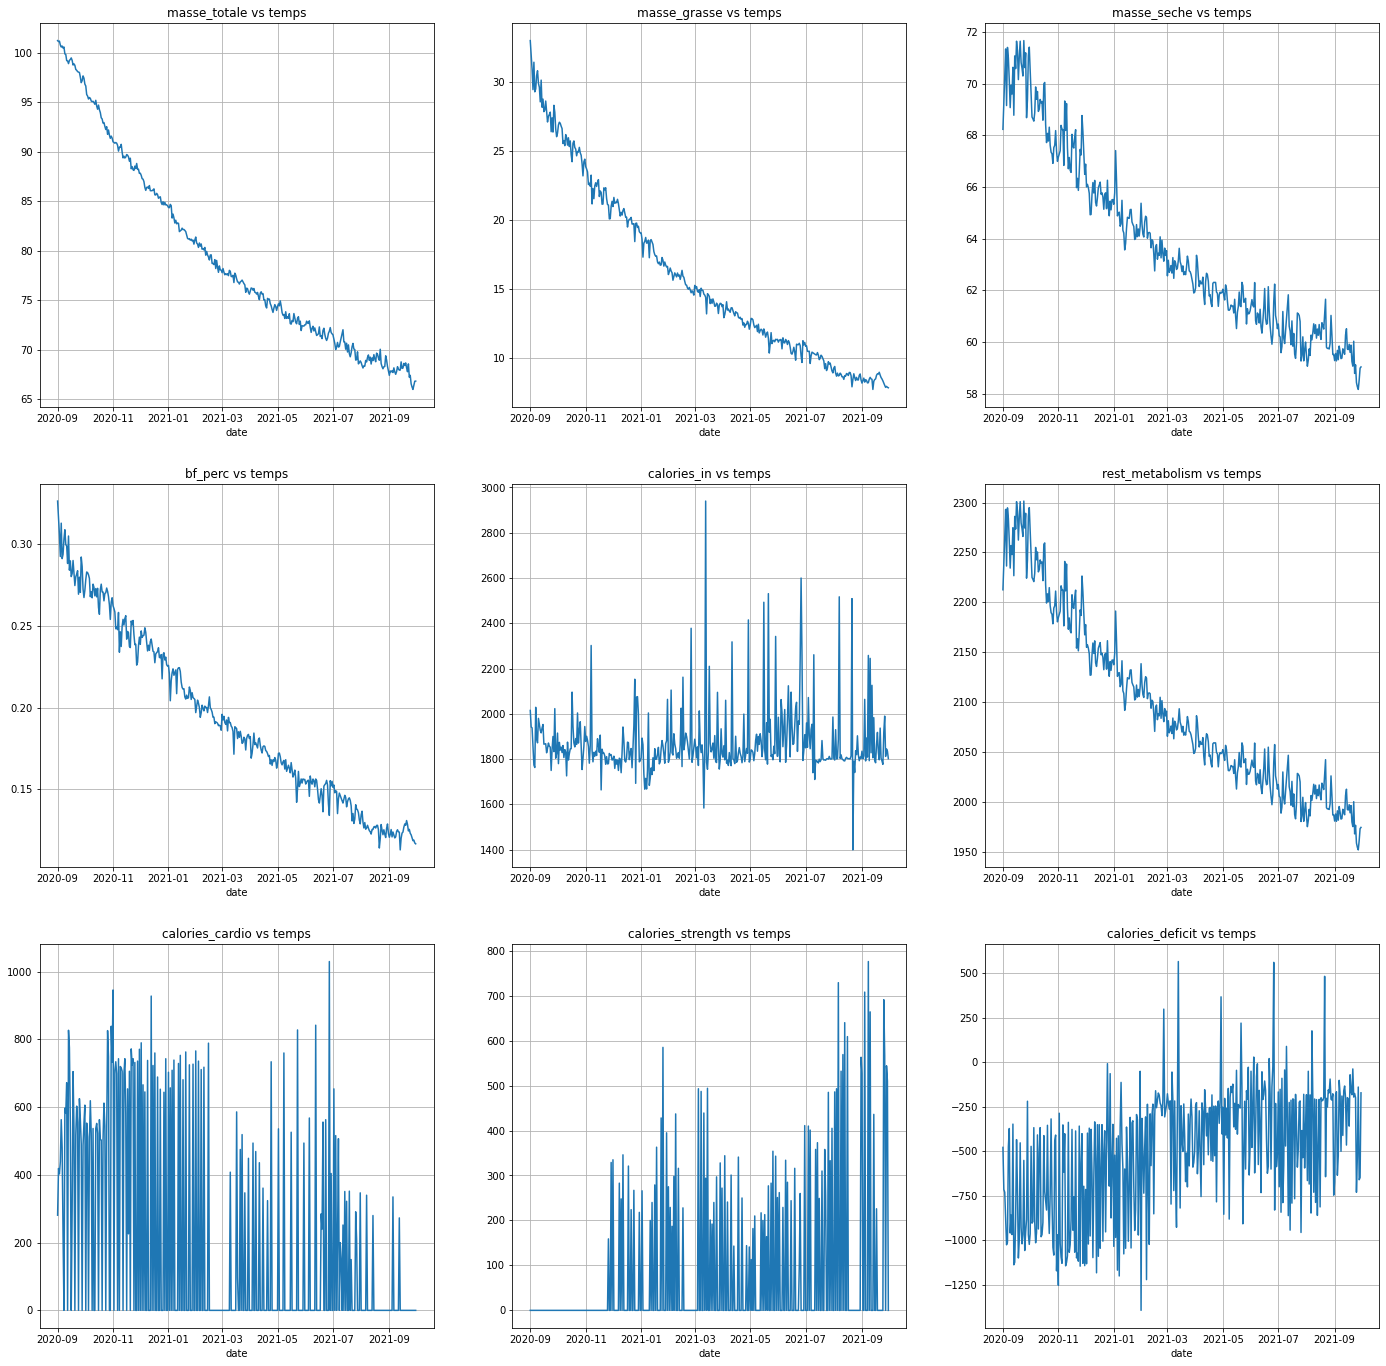

In [18]:
plot_columns(df=df_seche)

In [19]:
df_bulk

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,msj,oxf,sch,kma,base_metabolism,rest_metabolism,calories_deficit
date,,,,,,,,,,,,,,,,,,,
2021-10-01,66.591667,7.896667,1799.0,119.0,61.0,191.0,0.0,0.0,0.0,58.695000,1799.0,0.118583,1540.740750,1538.601667,1637.039600,1637.812000,1637.812000,1965.374400,-166.374400
2021-10-02,66.792857,7.887143,1974.0,183.0,31.0,124.0,770.0,0.0,770.0,58.905714,1204.0,0.118084,1542.750643,1541.458571,1639.347657,1642.363429,1642.363429,1970.836114,-766.836114
2021-10-03,67.018000,7.900000,2378.0,143.0,52.0,189.0,0.0,0.0,0.0,59.118000,2378.0,0.117879,1544.999820,1544.655600,1641.930496,1646.948800,1646.948800,1976.338560,401.661440
2021-10-04,66.783333,7.541667,2095.0,153.0,74.0,200.0,744.0,0.0,744.0,59.241667,1351.0,0.112927,1542.655500,1541.323333,1639.238400,1649.620000,1649.620000,1979.544000,-628.544000
2021-10-05,66.583333,7.953333,1799.0,174.0,48.0,152.0,0.0,0.0,0.0,58.630000,1799.0,0.119449,1540.657500,1538.483333,1636.944000,1636.408000,1636.408000,1963.689600,-164.689600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-15,68.200000,8.394615,2202.0,200.0,65.0,210.0,399.0,0.0,399.0,59.805385,1803.0,0.123088,1556.808000,1561.440000,1655.490400,1661.796308,1661.796308,1994.155569,-191.155569
2021-12-16,68.430000,8.601000,2099.0,206.0,46.0,213.0,340.0,0.0,340.0,59.829000,1759.0,0.125690,1559.105700,1564.706000,1658.128960,1662.306400,1662.306400,1994.767680,-235.767680
2021-12-17,68.665000,8.680000,2155.0,256.0,46.0,181.0,457.0,0.0,457.0,59.985000,1698.0,0.126411,1561.453350,1568.043000,1660.824880,1665.676000,1665.676000,1998.811200,-300.811200


In [20]:
df_bulk.describe()

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,msj,oxf,sch,kma,base_metabolism,rest_metabolism,calories_deficit
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,67.595684,8.206461,2146.100000,205.200000,57.362500,184.387500,305.550000,19.125000,286.425000,59.389223,1840.550000,0.121389,1550.770882,1552.858712,1648.557686,1652.807209,1652.807209,1983.368651,-142.818651
std,0.595645,0.260127,447.046074,70.062251,22.363648,30.952186,302.232239,85.233614,308.502827,0.437273,434.291389,0.003130,5.950490,8.458154,6.833235,9.445107,9.445107,11.334129,436.271523
min,66.171429,7.541667,1741.000000,71.000000,22.000000,95.000000,0.000000,0.000000,0.000000,58.334286,1204.000000,0.112927,1536.542571,1532.634286,1632.218629,1630.020571,1630.020571,1956.024686,-777.740800
25%,67.160938,8.022222,1812.750000,155.750000,44.750000,167.500000,0.000000,0.000000,0.000000,59.165679,1735.250000,0.118944,1546.427766,1546.685313,1643.570275,1647.978657,1647.978657,1977.574389,-265.234720
50%,67.606818,8.195000,2101.000000,198.500000,55.000000,184.500000,290.500000,0.000000,143.000000,59.358125,1796.000000,0.121357,1550.882114,1553.016818,1648.685418,1652.135500,1652.135500,1982.562600,-185.944000
75%,67.970000,8.411667,2297.250000,240.750000,62.250000,199.250000,558.000000,0.000000,550.250000,59.546250,1827.000000,0.124063,1554.510300,1558.174000,1652.851840,1656.199000,1656.199000,1987.438800,-150.690940
max,69.455000,8.811250,4785.000000,511.000000,184.000000,264.000000,920.000000,647.000000,920.000000,60.705000,4285.000000,0.128914,1569.345450,1579.261000,1669.887760,1681.228000,1681.228000,2017.473600,2306.276800


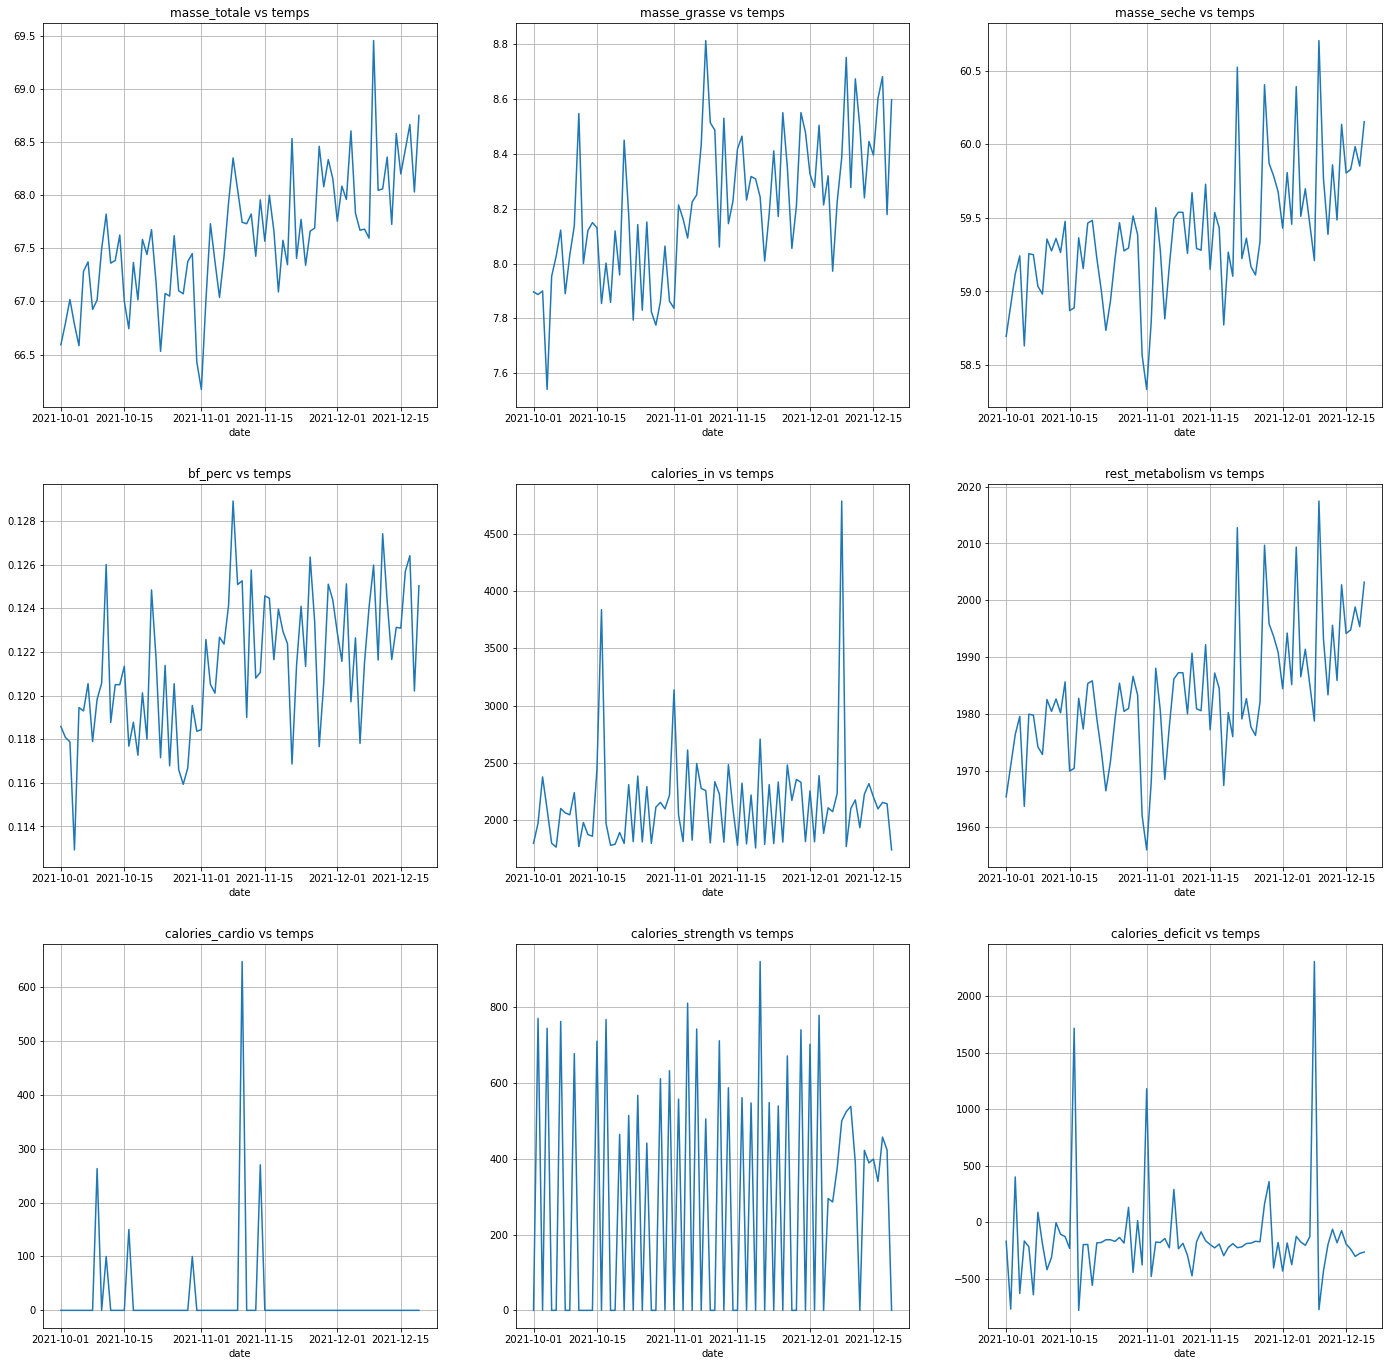

In [21]:
plot_columns(df=df_bulk)

# Quelles dynamiques sur les deux périodes ?

In [22]:
def plot_trends(df = df,
                columns_list = ['masse_totale',
                                'masse_seche',
                                'bf_perc']
                ):
    
    nb_cols_per_row = 3
    n = len(columns_list)
    
    if (n % nb_cols_per_row) == 0:
        n_rows = n // nb_cols_per_row
        n_cols = nb_cols_per_row
    else:
        n_rows = n // nb_cols_per_row + 1
        n_cols = nb_cols_per_row
        
    row_size = 8
    col_size = 8
    
    fig, axs = plt.subplots(nrows = n_rows, 
                            ncols = n_cols,
                            figsize=(row_size * nb_cols_per_row, 
                                     col_size * n_rows))
    
    if axs.ndim == 1: axs = axs[np.newaxis,:]  # required to make sure the axs array is actually 2D...
    
    for i, name in enumerate(columns_list):
        row_i = i // nb_cols_per_row
        col_i = i - row_i * nb_cols_per_row
        
        #------------- display -----------------------------------------------------------------------
        #--- raw data --------------------------------------------------------------------------------
        axs[row_i, col_i] = df[name].plot(ax=axs[row_i, col_i], title=name + f' vs temps',grid=True)
        #--- overall trend ---------------------------------------------------------------------------
        y = df[name]
        x_ord = np.array([d.toordinal() for d in df[name].index]).reshape(-1,1)
        lr = LinearRegression().fit(x_ord, y)
        y_pred = lr.predict(x_ord)
        axs[row_i, col_i].plot(df[name].index,y_pred)
        r = lr.score(x_ord, y)
        #--- numbers ---------------------------------------------------------------------------------
        print(f'rythme mensuel moyen sur la période de ' + name + f' = {np.round(lr.coef_[0] * 30,3)} avec coeff correlation = {np.round(r*100)}%')
        
    plt.show()

rythme mensuel moyen sur la période de masse_totale = -2.476 avec coeff correlation = 95.0%
rythme mensuel moyen sur la période de masse_seche = -0.861 avec coeff correlation = 92.0%
rythme mensuel moyen sur la période de bf_perc = -0.014 avec coeff correlation = 97.0%


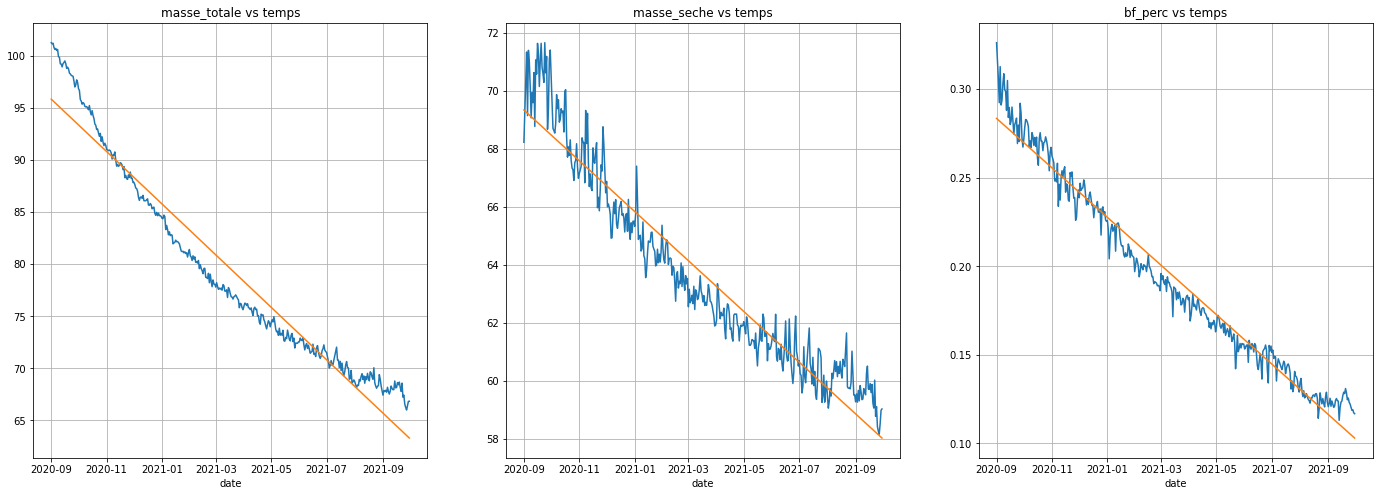

In [23]:
plot_trends(df_seche)

rythme mensuel moyen sur la période de masse_totale = 0.553 avec coeff correlation = 52.0%
rythme mensuel moyen sur la période de masse_seche = 0.342 avec coeff correlation = 37.0%
rythme mensuel moyen sur la période de bf_perc = 0.002 avec coeff correlation = 28.0%


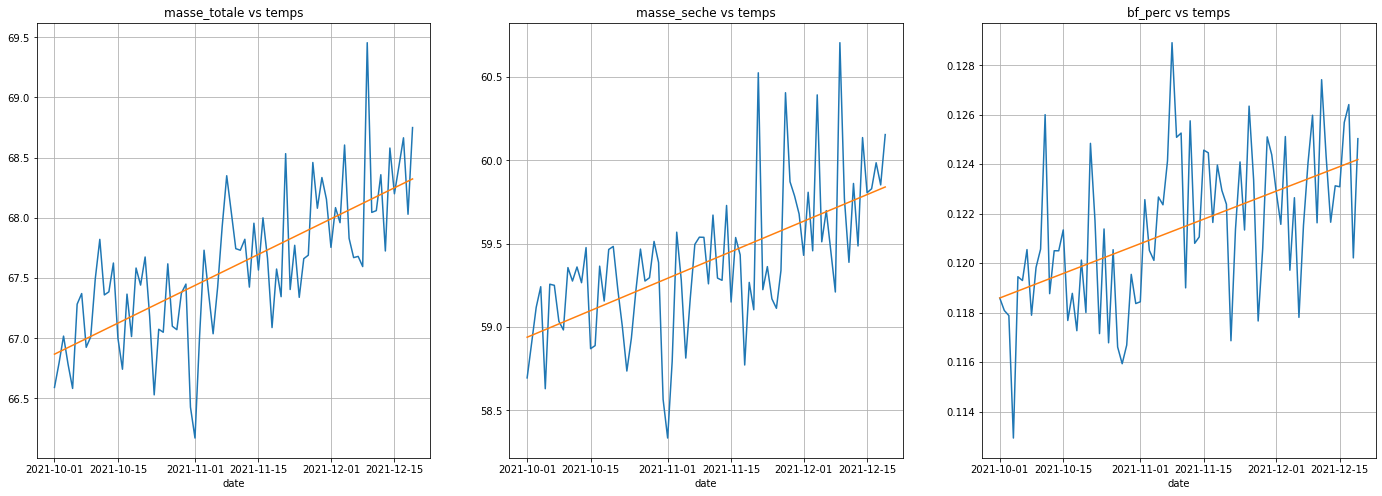

In [24]:
plot_trends(df_bulk)

# Quelle(s) différence(s) principale(s) entre ces deux périodes ??

In [25]:
def plot_boxes(df_seche = df_seche,
               df_bulk = df_bulk,
               columns_list = ['calories_in', 'calories_nettes', 
                               'rest_metabolism', 
                               'calories_deficit']):
    
    nb_cols_per_row = 3
    n = len(columns_list)
    
    if (n % nb_cols_per_row) == 0:
        n_rows = n // nb_cols_per_row
        n_cols = nb_cols_per_row
    else:
        n_rows = n // nb_cols_per_row + 1
        n_cols = nb_cols_per_row
    
    row_size = 6
    col_size = 6
    
    fig, axs = plt.subplots(nrows = n_rows, 
                            ncols = nb_cols_per_row,
                            figsize=(row_size * nb_cols_per_row, 
                                     col_size * n_rows))
    
    for i, name in enumerate(columns_list):
        row_i = i // nb_cols_per_row
        col_i = i - row_i * nb_cols_per_row
        
        data = [ df_seche[name],
                df_bulk[name]
                ]
        
        axs[row_i, col_i].set_title(name + ' par periode')
        axs[row_i, col_i].boxplot(data, labels = ['seche', 'bulk'], showmeans=True)
        axs[row_i, col_i].grid()
        
        m = np.round(df_seche[name].median())
        print(f'valeur médiane de ' + name + f' pendant la période seche = {m} kcals')
        m = np.round(df_bulk[name].median())
        print(f'valeur médiane de ' + name + f' pendant la période bulk = {m} kcals')
        print(f'---------------')
        
    plt.show()

valeur médiane de calories_in pendant la période seche = 1831.0 kcals
valeur médiane de calories_in pendant la période bulk = 2101.0 kcals
---------------
valeur médiane de calories_nettes pendant la période seche = 1654.0 kcals
valeur médiane de calories_nettes pendant la période bulk = 1796.0 kcals
---------------
valeur médiane de rest_metabolism pendant la période seche = 2071.0 kcals
valeur médiane de rest_metabolism pendant la période bulk = 1983.0 kcals
---------------
valeur médiane de calories_deficit pendant la période seche = -425.0 kcals
valeur médiane de calories_deficit pendant la période bulk = -186.0 kcals
---------------


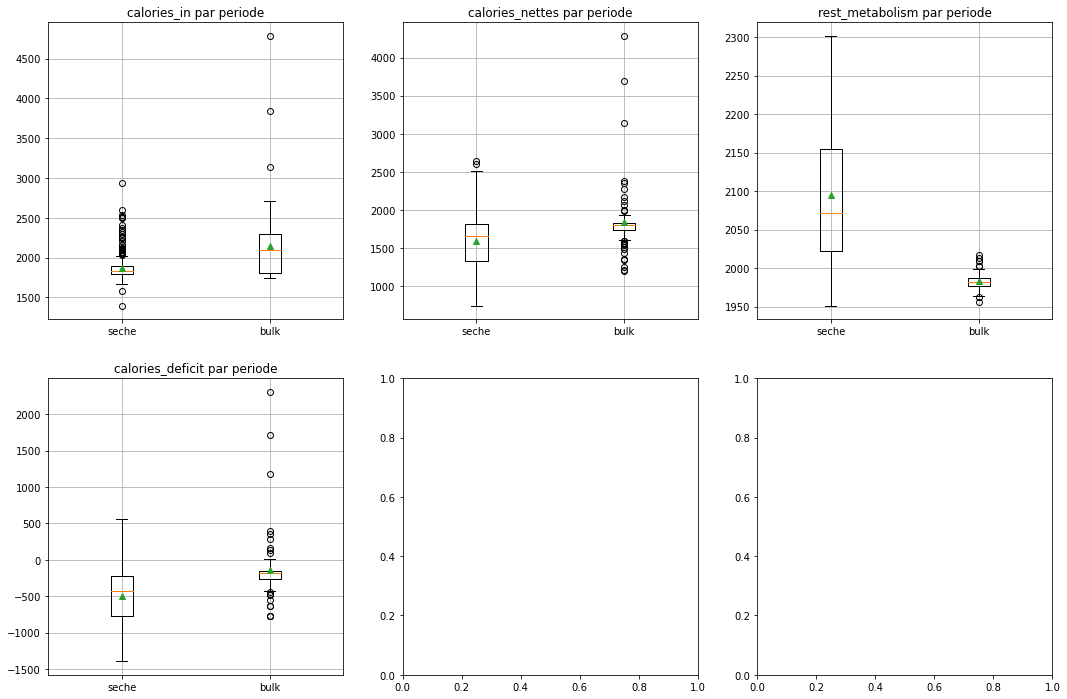

In [26]:
plot_boxes()

### En regardant les médianes seules des deux périodes (certes de longueur différente)
- calories nettes +144 kclas
- métabolisme repos (est) -127 kcals
- donc deficit calorique passe de -422 à -123 kcals

### Première recherche sur Masse Totale

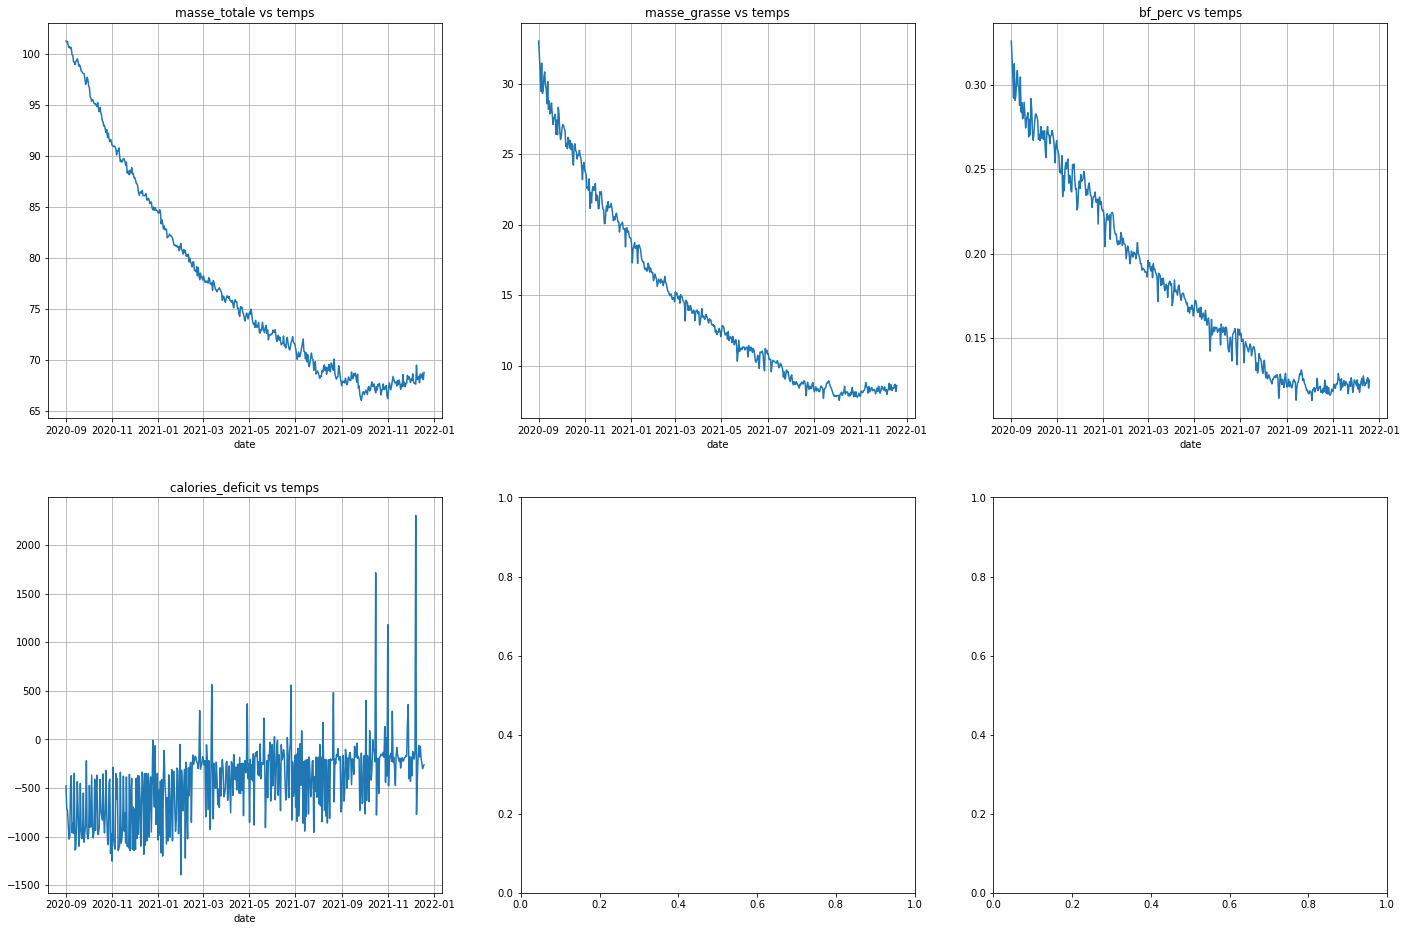

In [27]:
plot_columns(df=df, columns_list=['masse_totale','masse_grasse','bf_perc','calories_deficit'])

In [28]:
df['log_mt'] = df['masse_totale'].apply(np.log)

In [29]:
cut_off = datetime.date(2021,10,1)

df_seche = df[df.index < cut_off]
df_bulk = df[df.index >= cut_off]

rythme mensuel moyen sur la période de masse_totale = -2.476 avec coeff correlation = 95.0%
rythme mensuel moyen sur la période de log_mt = -0.031 avec coeff correlation = 97.0%


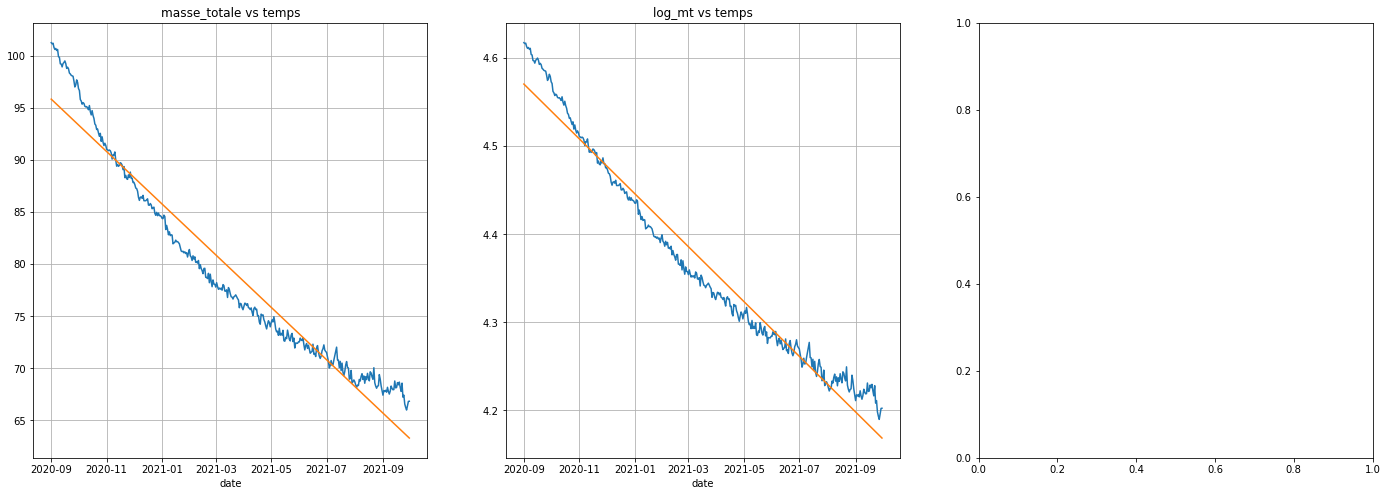

In [30]:
plot_trends(df=df_seche, columns_list=['masse_totale', 'log_mt'])

rythme mensuel moyen sur la période de masse_totale = 0.553 avec coeff correlation = 52.0%
rythme mensuel moyen sur la période de log_mt = 0.008 avec coeff correlation = 52.0%


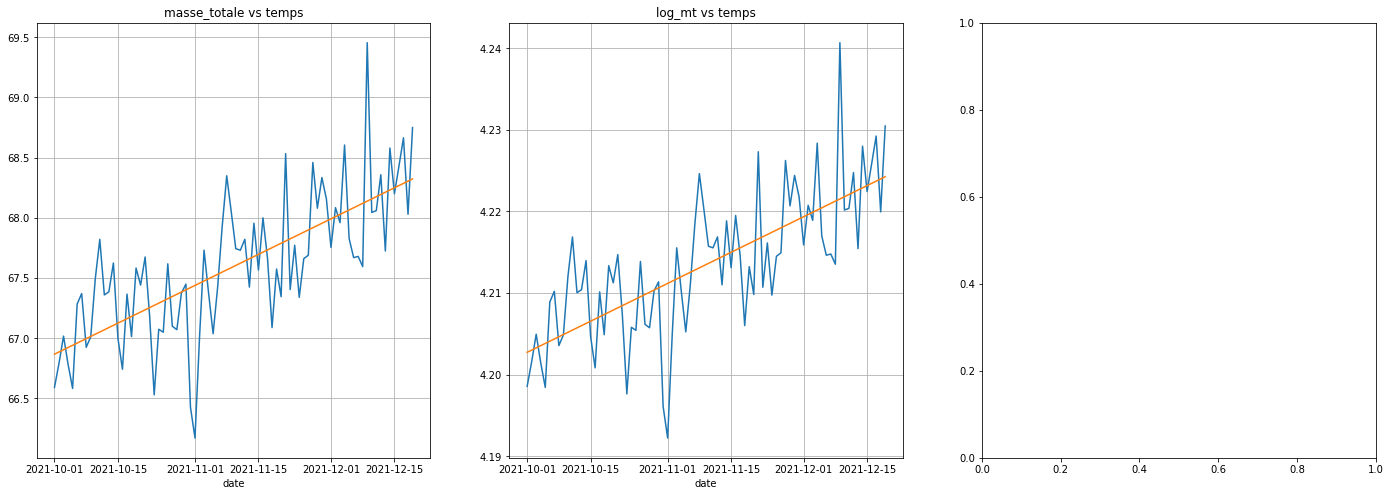

In [31]:
plot_trends(df=df_bulk, columns_list=['masse_totale', 'log_mt'])

### Hypothèse 1 : corrélation entre la variation de masse totale et le déficit calorique, sur une période de temps à déterminer

In [32]:
df_test = df[['masse_totale', 'calories_deficit']]
df_test

,masse_totale,calories_deficit
date,,
2020-09-01,101.250,-478.521600
2020-09-02,101.150,-714.793600
2020-09-03,101.200,-730.398400
2020-09-04,100.800,-881.132800
2020-09-05,100.600,-1025.368000
...,...,...
2021-12-15,68.200,-191.155569
2021-12-16,68.430,-235.767680
2021-12-17,68.665,-300.811200


In [33]:
window = 15

In [34]:
df_test['variation_masse_moyenne'] = df['masse_totale'].diff(1).rolling(window).mean()
df_test['deficit_moyen'] = df['calories_deficit'].rolling(window).mean().shift(1)

df_test = df_test[window:]

C:\Users\BENJAM~1.DEP\AppData\Local\Temp/ipykernel_9392/2261957549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['variation_masse_moyenne'] = df['masse_totale'].diff(1).rolling(window).mean()
C:\Users\BENJAM~1.DEP\AppData\Local\Temp/ipykernel_9392/2261957549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['deficit_moyen'] = df['calories_deficit'].rolling(window).mean().shift(1)


In [35]:
df_test.head(5)

# variation masse moyenne = (masse J - masse à J-window) / window
# deficit moyen = deficit calorique moyenné sur la window

,masse_totale,calories_deficit,variation_masse_moyenne,deficit_moyen
date,,,,
2020-09-16,99.500000,-434.9088,-0.116667,-797.230720
2020-09-17,99.250000,-717.5776,-0.126667,-794.323200
2020-09-18,98.783333,-1099.3744,-0.161111,-794.508800
2020-09-19,98.900000,-998.2272,-0.126667,-819.107200
2020-09-20,98.750000,-452.9088,-0.123333,-826.913493


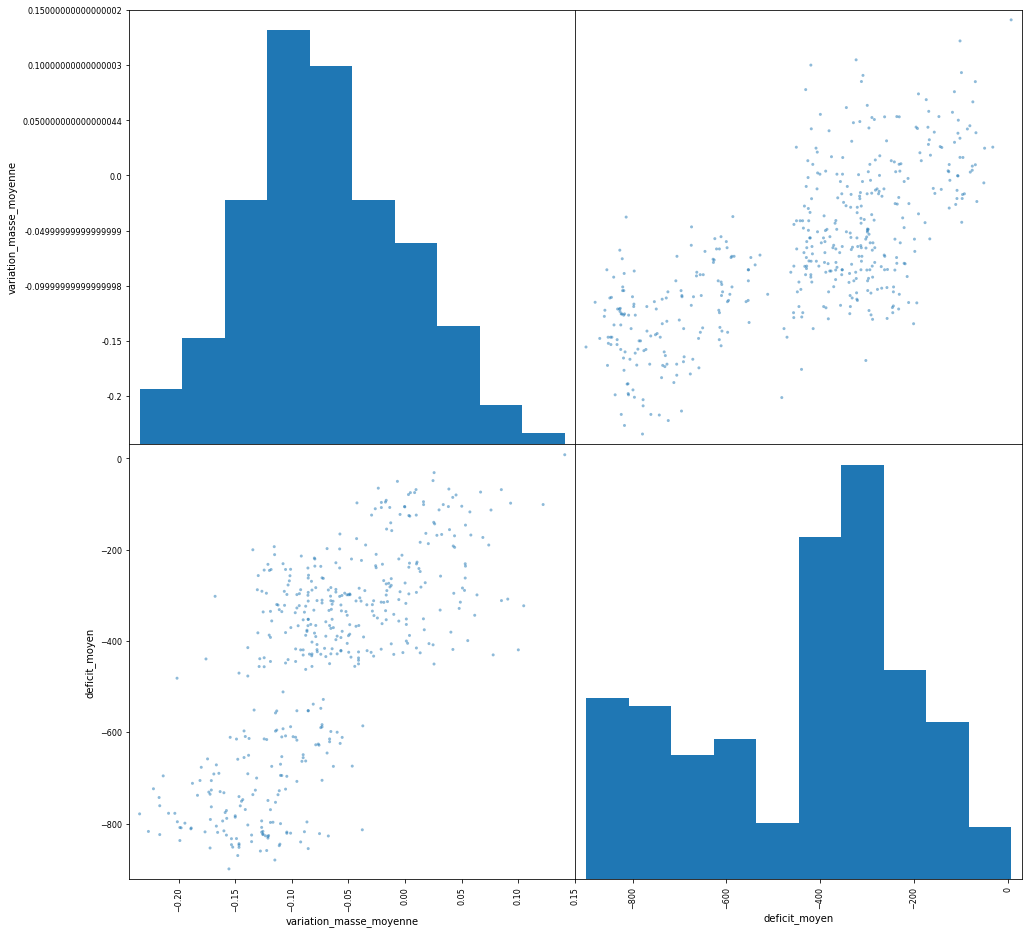

In [36]:
pd.plotting.scatter_matrix(df_test[['variation_masse_moyenne','deficit_moyen']], figsize=(16,16))
plt.show()

In [37]:
df_test.corr()

# NB : la moyenne de la variation journalière de poids corrèle mieux avec le déficit calorique que la variation brute

,masse_totale,calories_deficit,variation_masse_moyenne,deficit_moyen
masse_totale,1.000000,-0.533321,-0.695061,-0.898592
calories_deficit,-0.533321,1.000000,0.388814,0.525531
variation_masse_moyenne,-0.695061,0.388814,1.000000,0.714512
deficit_moyen,-0.898592,0.525531,0.714512,1.000000


On va tracer l'autocorrélation, pour savoir à quel ordre différencier pour stationnariser

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [39]:
def describe_order(df, name):
    
    fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       figsize=(12,12))
    
    df.plot(ax=ax[0,0], grid=True)
    ax[0,0].set_title(name)
    
    df.plot.hist(ax=ax[0,1], grid=True)
    ax[0,1].set_title(name)
    
    plot_acf(df, ax=ax[1,0])
    plot_pacf(df, ax=ax[1,1], method='ywm')
    
    plt.show()

Ordre 0

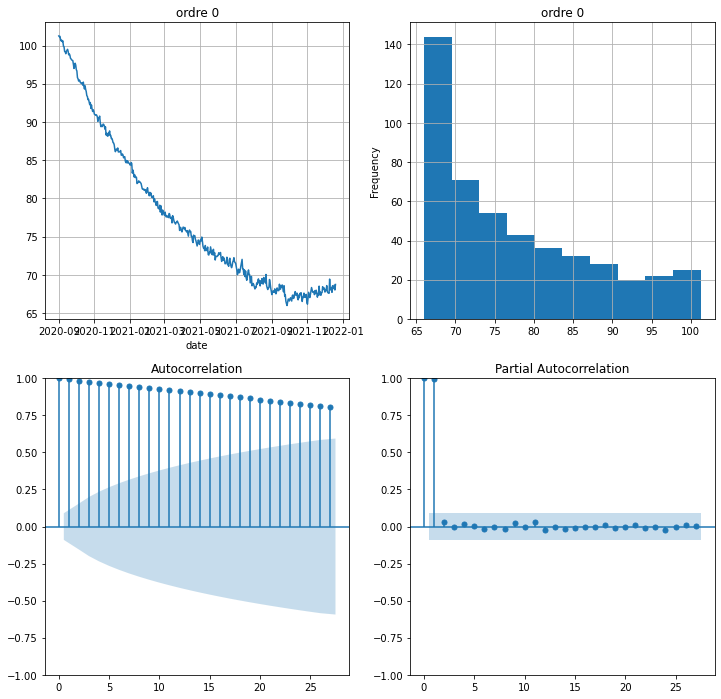

In [40]:
d0_mt = df['masse_totale']

describe_order(d0_mt, 'ordre 0')

Ordre 1

In [41]:
d1_mt = d0_mt.diff()[1:]

d1_mt.describe()

count    474.000000
mean      -0.068565
std        0.441545
min       -1.440000
25%       -0.366667
50%       -0.086023
75%        0.232500
max        1.859545
Name: masse_totale, dtype: float64

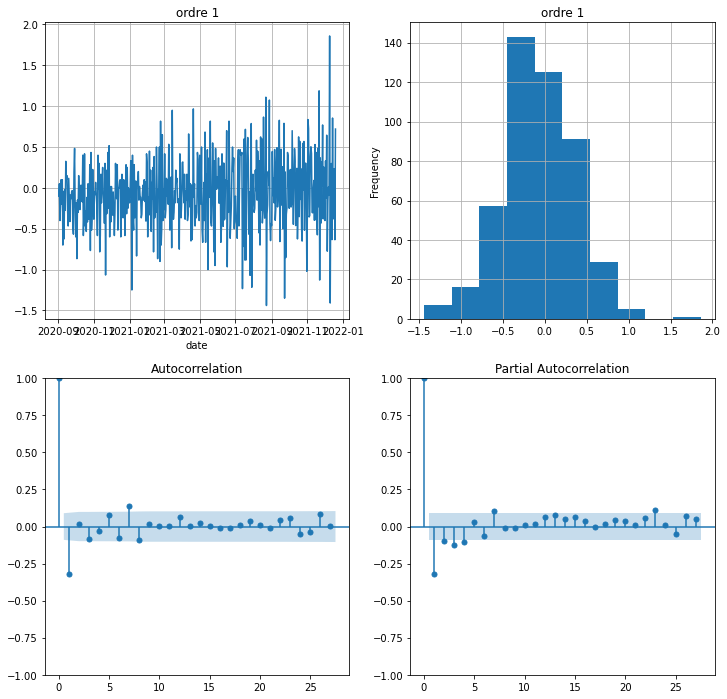

In [42]:
describe_order(d1_mt, 'ordre 1')

Ordre 2

In [43]:
d2_mt = d1_mt.diff()[1:]
d2_mt.describe()

count    473.000000
mean       0.001734
std        0.716873
min       -3.269091
25%       -0.433333
50%        0.018750
75%        0.475000
max        1.944091
Name: masse_totale, dtype: float64

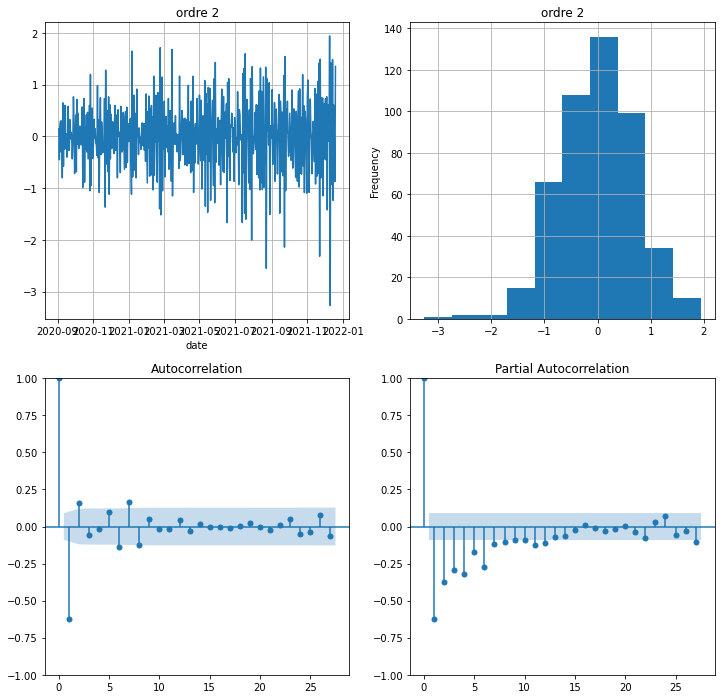

In [44]:
describe_order(d2_mt, 'ordre 2')

Ordre 3...

In [45]:
d3_mt = d2_mt.diff()[1:]
d3_mt.describe()

count    472.000000
mean       0.002553
std        1.291603
min       -5.213182
25%       -0.816667
50%        0.072024
75%        0.866667
max        4.693182
Name: masse_totale, dtype: float64

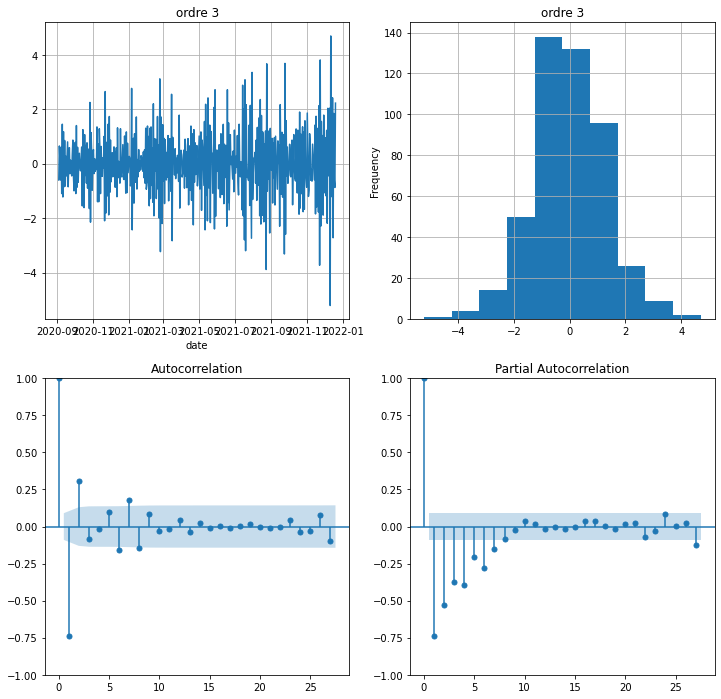

In [46]:
describe_order(d3_mt, name='ordre 3')

Ordre 4

In [47]:
d4_mt = d3_mt.diff()[1:]
d3_mt.describe()

count    472.000000
mean       0.002553
std        1.291603
min       -5.213182
25%       -0.816667
50%        0.072024
75%        0.866667
max        4.693182
Name: masse_totale, dtype: float64

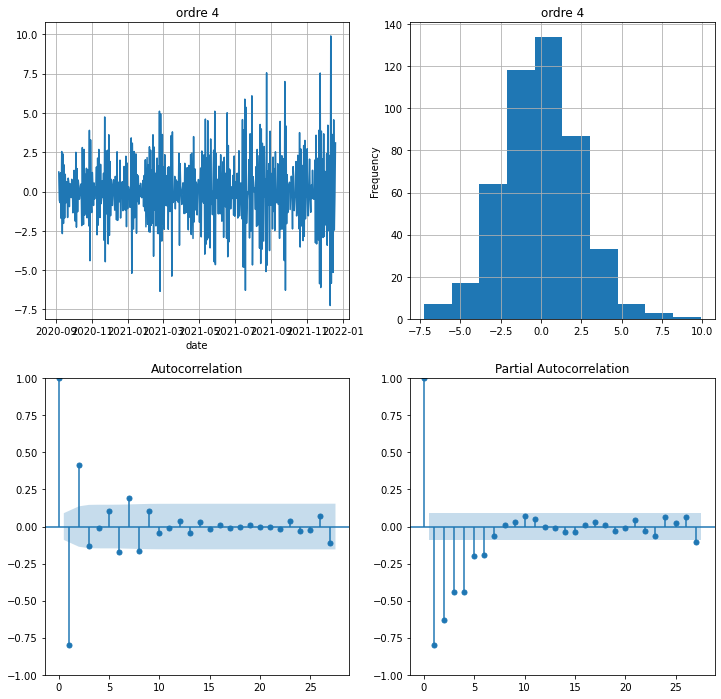

In [48]:
describe_order(d4_mt, name='ordre 4')